In [11]:
import numpy as np
import pandas as pd
import torch 

#Visualize and create graph/charts
import networkx as nx
import matplotlib.pyplot as plt

#Path managment
import os
import sys

from IPython.display import clear_output
torch.__version__

'2.2.2'

### Add the DGDNN libraries int the path

In [23]:
model_path = os.path.abspath('/Users/mirco/Documents/Tesi/code/models/DGDNN/Model')
if model_path not in sys.path:
    sys.path.insert(0, model_path)

# Code to handle to create and handle the dataset

In [6]:
from models.DGDNN.Data.geometric_dataset_gen import MyDataset as MyGeometricDataset
from models.DGDNN.Data.dataset_gen import MyDataset 

In [7]:
%reload_ext autoreload
%autoreload 2

In [12]:
dir = 'data/datasets/America_Stocks_reduced'
dest = 'data/datasets/graph/'
market = 'NASDAQ'
company_list = ['AAPL', 'AMZN', 'AMRK', 'APOG', 'ACWI',
'ADSK',
'ADTN',
'ADUS',
'AEGN']
start_date = '2010-01-01'
end_date = '2015-12-31'
window_size = 30  # 30 days window
dataset_label = 'train'
use_fast_approximation = False

# Create a dataset instance
dataset = MyGeometricDataset(
    root=dir,
    desti=dest,
    market=market,
    comlist=company_list,
    start=start_date,
    end=end_date,
    window=window_size,
    dataset_type=dataset_label,
    fast_approx=use_fast_approximation
)


In [9]:
print(f"Number of snapshots graph of the dataset: {len(dataset)}")
print(f"Graph snapshot structure: {dataset[0]}")
print(f"Number of nodes: {len(dataset[0].x)}")
print(f"Number of target labels: {len(dataset[0].y)}")

Number of snapshots graph of the dataset: 415
Graph snapshot structure: Data(x=[9, 150], edge_index=[2, 81], edge_attr=[81], y=[9])
Number of nodes: 9
Number of target labels: 9



Visualizing Graph...
Number of nodes: 9
Number of edges: 45


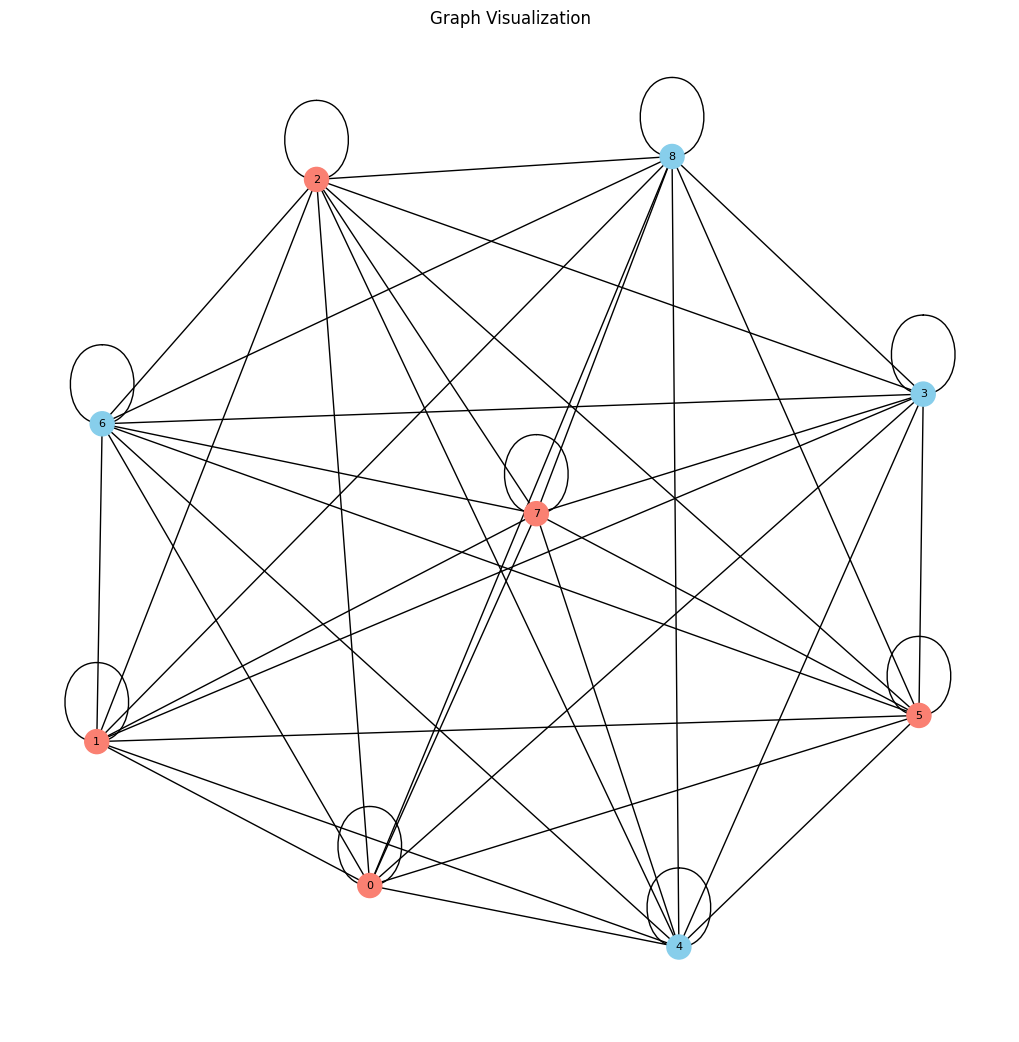

In [13]:
# --- Assume 'dataset' is your initialized MyGeometricDataset ---

def visualize_geometric_graph(data_sample):
    """
    Visualizes a single torch_geometric.data.Data graph sample.
    """
    # Create a NetworkX graph object
    G = nx.Graph()

    # The edge_index tensor is of shape [2, num_edges].
    # We need to transpose it and convert to a list of tuples.
    edge_list = data_sample.edge_index.t().tolist()

    # Add edges to the graph. Nodes are added automatically.
    G.add_edges_from(edge_list)

    print(f"\nVisualizing Graph...")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Use the labels (Y tensor) to color the nodes
    # For example, class 0 is blue, class 1 is red
    colors = ['skyblue' if label == 0 else 'salmon' for label in data_sample.y]

    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, with_labels=True, node_color=colors, node_size=300, font_size=8)
    plt.title("Graph Visualization")
    plt.show()

# Visualize the first graph in the dataset

visualize_geometric_graph(dataset[2])


# Model 1: GConvGRU

In [14]:
from torch_geometric_temporal.nn import GConvGRU

/Users/mirco/Documents/Tesi/code/tesi_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Model 2: DGDNN

GitHub: https://github.com/pixelhero98/DGDNN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader # For batching graph data
from torch_geometric.utils import to_dense_adj
from dgdnn import DGDNN 

In [25]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example Hyperparameters (Adjust these based on your needs and data)
num_nodes = 9  # From your data.x.shape[0]
node_features_dim = dataset[0].x.shape[1] # From your data.x.shape[1]

# diffusion_size: Must start with node_features_dim
diffusion_size = [node_features_dim, 128, 64] 
# embedding_size: Related to CatMultiAttn inputs/outputs
# embedding_size[0] could be diffusion_size[-1]
# The last element embedding_size[-1] is used for the linear layer
embedding_size = [
    diffusion_size[1] + node_features_dim,  # Input to CatAttn[0] (278)
    128,                                    # Output from CatAttn[0], arbitrary choice
    diffusion_size[2] + 128,                # Input to CatAttn[1] (64 + 128 = 192)
    256                                     # Output from CatAttn[1], arbitrary choice for final embed
]
classes = 1

dgdnn_layers = len(diffusion_size) - 1 # Number of diffusion layers
expansion_step = 5 # Example value, this is for self.T parameter
num_heads = 1     # Example for CatMultiAttn

# active: list of activation functions for each layer
# For example, one nn.ReLU per layer in DGDNN
active_layers = [True] * dgdnn_layers # Or list of [nn.ReLU(), nn.ReLU(), ...]

# timestamp: Passed to CatMultiAttn and used in the final linear layer
# If processing single snapshots and CatMultiAttn output dim is embedding_size[-1],
# and the linear layer takes embedding_size[-1]*timestamp, this implies timestamp=1
# for a direct match. Or CatMultiAttn's output must already be embedding_size[-1]*timestamp.
# Let's assume CatMultiAttn outputs embedding_size[2*i+1] and for the final linear layer
# the input h has feature dim embedding_size[-1].
# If so, set timestamp=1.
model_timestamp = 1 

model = DGDNN(
    diffusion_size=diffusion_size,
    embedding_size=embedding_size,
    classes=1,
    layers=dgdnn_layers,
    num_nodes=num_nodes,
    expansion_step=expansion_step,
    num_heads=num_heads,
    active=active_layers,
    timestamp=model_timestamp
).to(device)

print(f"Numbero of parameters: {sum([p.numel() for p in model.parameters()])}")

Numbero of parameters: 572257


In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() # For binary classification (output is a single logit)
num_epochs = 2 # Example

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader: # data will be a Batch object, even with batch_size=1
        data = data.to(device)
        optimizer.zero_grad()

        # Extract node features
        # For batch_size=1, data.x is [num_nodes, node_features_dim]
        X = data.x 

        # Convert edge_index and edge_attr to a dense adjacency matrix
        # For batch_size=1, to_dense_adj returns [1, num_nodes, num_nodes]
        # Squeeze it to get [num_nodes, num_nodes] as expected by the model.
        A = to_dense_adj(data.edge_index, 
                         batch=data.batch, # Important for correct batch processing if batch_size > 1
                         edge_attr=data.edge_attr, 
                         max_num_nodes=num_nodes).squeeze(0) # Squeeze for batch_size=1

        # Forward pass
        # DGDNN expects X: [num_nodes, features], A: [num_nodes, num_nodes]
        outputs = model(X, A) # Output shape: [num_nodes, classes]

        # Calculate loss
        # data.y shape: [num_nodes]
        if classes == 1 : # BCEWithLogitsLoss expects float labels
             loss = criterion(outputs.squeeze(-1), data.y.float())
        else: # CrossEntropyLoss expects long labels
             loss = criterion(outputs, data.y.long())


        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training finished.")

Epoch 1/2, Average Loss: 0.7136
Epoch 2/2, Average Loss: 0.7014
Training finished.


## Temp maybe usefull

In [13]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal #Handle dynamic temporal graph